In [187]:
# import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Dropout
from tensorflow.python.keras.models import Sequential
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt

In [188]:
# read in file
df = pd.read_csv('Churn_modelling.csv')

In [211]:
# view first 5 records
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [212]:
# separate continuous and categorical features
features = df.drop(['RowNumber','CustomerId','Surname','Exited'],axis=1)
cont_features = features.select_dtypes(include=[np.number])
cat_features = features.select_dtypes(include=['bool'])
encoded_cat_features = pd.get_dummies(features[['Geography','Gender']])

In [213]:
# standardize continuous features 
scaler = StandardScaler()
cont_features_scaled = pd.DataFrame(scaler.fit_transform(cont_features),
                                    columns=scaler.get_feature_names_out())

In [214]:
# join scaled continuous features with categorical features
# select 'Exited' as target variable
X = pd.concat((cont_features_scaled,encoded_cat_features),axis=1)
y = df['Exited']

In [215]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [216]:
# create cross-validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25)

In [250]:
# define model architecture with hyperparameter variables 
def create_model(neurons1,neurons2,lr,dr1,dr2):
        
        model = keras.Sequential([
        #keras.layers.Input(shape=(None,10,13)),
        keras.layers.Dense(units=neurons1,activation='sigmoid'),
        keras.layers.Dropout(rate=dr1),
        keras.layers.Dense(units=neurons2,activation='sigmoid'),
        keras.layers.Dropout(rate=dr2),
        keras.layers.Dense(units=1,activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate=lr))

        return model

# set hyperparameter tuning ranges
def build_model(hp):

    neurons1 = hp.Int("units1", min_value=6, max_value=24)
    neurons2 = hp.Int("units2", min_value=6, max_value=24)
    lr = hp.Float("learning_rate", min_value=1e-4,max_value=1e-2)
    dr1 = hp.Float("dropout_rate1", min_value=0.2,max_value=0.5)
    dr2 = hp.Float("dropout_rate2", min_value=0.2,max_value=0.5)
    
    model = create_model(
        neurons1=neurons1,
        neurons2=neurons2,
        lr=lr,
        dr1=dr1,
        dr2=dr2
        )
    return model

In [251]:
# initialize Bayesian Optimimization hyperparameter tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True
)

In [252]:
# search combinations of hyperparameters for optimal outputs
tuner.search(X_train,y_train,epochs=10,validation_data=(X_val,y_val),batch_size=10)
best_model = tuner.get_best_models()[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 24s]
val_loss: 0.3935874402523041

Best val_loss So Far: 0.3481932282447815
Total elapsed time: 00h 04m 09s
INFO:tensorflow:Oracle triggered exit


In [254]:
# view individual optimal hyperparameters
print("best units1: ", best_hps.get('units1'))
print("best units2: ", best_hps.get('units2'))
print("best lr: ", best_hps.get('learning_rate'))
print("best dr1: ", best_hps.get('dropout_rate1'))
print("best dr2: ", best_hps.get('dropout_rate2'))

best units1:  22
best units2:  13
best lr:  0.007216151732650057
best dr1:  0.2247048727763524
best dr2:  0.23128584772321611


In [256]:
# select model with best hyperparameters and fit to training data
best_model = tuner.get_best_models()[0]
history = best_model.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 2, validation_data = (X_val,y_val))
best_model.summary()

Epoch 1/100
750/750 - 3s - loss: 0.3596 - accuracy: 0.8521 - val_loss: 0.3466 - val_accuracy: 0.8604 - 3s/epoch - 4ms/step
Epoch 2/100
750/750 - 2s - loss: 0.3587 - accuracy: 0.8516 - val_loss: 0.3434 - val_accuracy: 0.8600 - 2s/epoch - 3ms/step
Epoch 3/100
750/750 - 2s - loss: 0.3580 - accuracy: 0.8519 - val_loss: 0.3492 - val_accuracy: 0.8616 - 2s/epoch - 3ms/step
Epoch 4/100
750/750 - 2s - loss: 0.3545 - accuracy: 0.8556 - val_loss: 0.3464 - val_accuracy: 0.8600 - 2s/epoch - 3ms/step
Epoch 5/100
750/750 - 2s - loss: 0.3524 - accuracy: 0.8544 - val_loss: 0.3460 - val_accuracy: 0.8584 - 2s/epoch - 3ms/step
Epoch 6/100
750/750 - 2s - loss: 0.3514 - accuracy: 0.8537 - val_loss: 0.3529 - val_accuracy: 0.8612 - 2s/epoch - 3ms/step
Epoch 7/100
750/750 - 2s - loss: 0.3488 - accuracy: 0.8541 - val_loss: 0.3436 - val_accuracy: 0.8564 - 2s/epoch - 3ms/step
Epoch 8/100
750/750 - 2s - loss: 0.3503 - accuracy: 0.8536 - val_loss: 0.3457 - val_accuracy: 0.8572 - 2s/epoch - 3ms/step
Epoch 9/100
750/

In [263]:
# evaluate model performance
best_model.evaluate(X_test,y_test,verbose=1)

63/63 [==============================] - 0s 2ms/step - loss: 0.3161 - accuracy: 0.8710
test loss:  0.31609538197517395
test accuracy:  0.8709999918937683


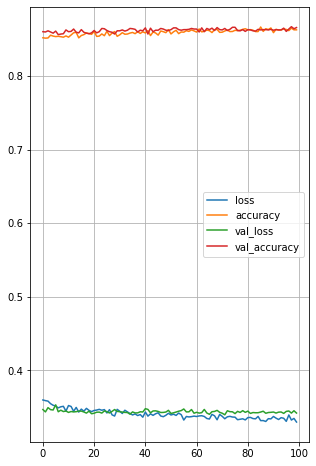

In [257]:
# view historical training performance
pd.DataFrame(history.history).plot(figsize=(5,8))
plt.grid(True)
#plt.gca()
plt.show()

In [264]:
# generate predictions using test dataset (has not been seen by model)
y_pred = best_model.predict(X_test)
y_pred = (y_pred>0.5)
conf_matrix = confusion_matrix(y_test.values, y_pred)
conf_matrix

63/63 [==============================] - 0s 2ms/step


array([[1552,   33],
       [ 225,  190]], dtype=int64)

<AxesSubplot:>

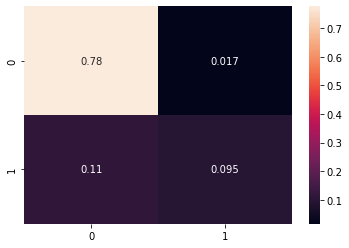

In [265]:
# visualize percentages of [TP, FP], [FN, TN]
sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True)

In [266]:
# further evaluate model performance for tuning
print("precision: ", precision_score(y_test, y_pred))
print("recall: ", recall_score(y_test, y_pred))
print("f1 score: ", f1_score(y_pred, y_test))

precision:  0.852017937219731
recall:  0.4578313253012048
f1 score:  0.5956112852664577
